# Laboratorium 6 - Znajdowanie pierwiastków

Konrad Dębiec

## Zadanie A

### Wstęp

In [3]:
using Roots
using Plots 
using ForwardDiff
f(x) = cos(x) - x*2

f (generic function with 1 method)

Do wykonania zadania wybrałem poniższe metody:

#### 1. Metoda wykorzytująca przedział i zmianę znaku - Metoda bisekcji

Jest najbardziej dokładną metodą na znalezienie pierwiastków równania $f(x)=0$ nieliniowego z 1 zmienną spełniającego założenia:

* $f(x)$ jest ciągła na $[a,b]$
* funkcja przyjmuje róźne znaki na krańcach $f(a)f(b) < 0$

Metoda używa fakt że jeśli funkcja zmienia znak w przedziale $[a, b]$ to $\exists c \in [a, b]: f(c)=0$

Algorytm polega na podziale początkowego przedziału na pół i wybieraniu przedziału który zawiera pierwiastek ($f(c)f(kraniec) < 0$).

Metoda gwarantuje znalezienie pierwiastka w sytuacji kiedy zachodzą wymienione warunki, ale jej rząd zbieżności jest liniowy (metoda jest dokładna, ale wolna)

In [4]:
find_zero(f, (0,1), Bisection())

0.45018361129487355

#### 2. Metoda wykorzystująca pochodną - Metoda Newtona

Metoda przyjmuje takie założenia co do funkcji $f$:

* W przedziale $[a, b]$ znajduje się dokładnie 1 pierwiastek
* $f(a)f(b) < 0$
* pierwsza i druga pochona mają stały znak w przedziale $[a, b]$

Algorytm: 

* wybieramy punkt początkowy $x_{0}$ (najczęściej $a$ lub $b$)
* dla uzyskania kolejnego przybliżenia pierwiastka przez punkt $x_{n}$ przeprowadzamy styczną, punk przecięcia stycznej i osi $OX$ jest kolejnym przybliżeniem pierwiastka
* powtarzamy kolejny krok póki nie osiągniemy wystarczające przybliżenie lub nie przekroczymy maksymalnej ilości kroków

Metoda Newtona nie zawsze będzie zbieżna, ponieważ rozwinięcie Taylora z pominięciem składników stopnia wyższego niż 1 wymaga żeby punkt $x_{n}$ znalazł się wystarczająco blisko $\alpha$. 
Co można osiągnąć jeśli przed zastosowaniem metody Newtona uzyskamy przybliżenie rozwiązania stabilniejszą, ale wolniejsą metodą np. bisekcji przeprowadzając kilka iteracji.

Metoda Newtona potrzebuje dużo mniej iteracij dla uzyskania odpowiedniego przybliżenia w porównaniu z metodą bisekcji

In [5]:
D(f) = x->ForwardDiff.derivative(f, float(x))
find_zero((f, D(f)), 0, Roots.Newton())

0.45018361129487383

#### 3. Metoda wykorzystująca przybliżenie pochodnej - Metoda siecznych

Metoda należy do klasy quasi-Newtonowskich (nie wymaga wyliczania pochodnej w punkcie, a więc nie wymaga różniczkowalności) 

Wzór na kolejne przybliżenia można wyprowadzić z wzoru na metodę Newtona podstawiając różniczę skończoną do wzoru:

$$x_{n} = x_{n-1} - \dfrac{f(x_{n-1})}{f'(x_{n-1})}$$
$$f'(x_{n-1}) = \dfrac{f(x_{n-1}) - f(x_{n-2})}{x_{n-1} - x_{n-2}}$$

Czyli wzór stosowany w metodzie siecznych: $x_{n} = x_{n-1} - f(x_{n-1})\dfrac{x_{n-1} - x_{n-2}}{f(x_{n-1}) - f(x_{n-2})}$

Metoda siecznych dla zbieżności wymaga żeby porzątkowe wartości (krańce przedziałów) były "wystarczająco" blisko szukanego rozwiązania (jak w metodzie Newtona).

In [6]:
find_zero(f, 0, Order1())

0.45018361129487355

### Zadanie A.1 - Testowanie metod

Do testowania wybrałem następujące funkcje:

In [7]:
f1(x) = sin(x) - x/2
f2(x) = 2*x - exp(-x)
f3(x) = x^3
f4(x) = cos(x) - x
f5(x) = x^3 - 2*x - 5
f6(x) = (x-1)^7
funcs = [f1, f2, f3, f4, f5, f6]

6-element Array{Function,1}:
 f1
 f2
 f3
 f4
 f5
 f6

Aby wyświetlać informacje w tabeli korzystam z pakietu "PrettyTables"

In [8]:
using PrettyTables

┌ Info: Precompiling PrettyTables [08abe8d2-0d0c-5749-adfa-8a2ac140af0d]
└ @ Base loading.jl:1260


In [9]:
# Funkcja, która przechwytuje wyjście na konsole
function getOutputOfFindZero(first_arg, second_arg, third_arg)
    output = ""
    x = 0
    let old_stdout = stdout
        rd, = redirect_stdout()
        try
            x = find_zero(first_arg, second_arg, third_arg, verbose=true)
        finally
            redirect_stdout(old_stdout) # Przywraca oryginalne stdout
        end
        output = String(readavailable(rd))
    end
    
    return x, output
end

getOutputOfFindZero (generic function with 1 method)

In [10]:
function check_zero(f, x)
    return iszero(f(x)) || f(prevfloat(x)) * f(x) < 0.0 || f(x) * f(nextfloat(x)) < 0.0
end

check_zero (generic function with 1 method)

In [11]:
function testFunctionsAndBuildTable(funcs::Array{Function,1})
    table = Array{Any}
    for i in eachindex(funcs)
        ## Bisection
        funcTable = []
        x, output = getOutputOfFindZero(funcs[i], (-5,5), Bisection())
        iterations = match(r"(?<=iterations: )(\d+)", output).match
        func_evaluations = match(r"(?<=function evaluations: )(\d+)", output).match

        push!(funcTable, i)
        push!(funcTable, 1)
        push!(funcTable, check_zero(funcs[i], x))
        push!(funcTable, round(x, digits=6))
        push!(funcTable, parse(Int64,iterations))
        push!(funcTable, parse(Int64,func_evaluations))
        
        table = [table; funcTable']
        
        ## Newton
        funcTable = []
        D(f) = x->ForwardDiff.derivative(f, float(x))
        x, output = getOutputOfFindZero((funcs[i], D(funcs[i])), 0, Roots.Newton())
        iterations = match(r"(?<=iterations: )(\d+)", output).match
        func_evaluations = match(r"(?<=function evaluations: )(\d+)", output).match

        push!(funcTable, i)
        push!(funcTable, 2)
        push!(funcTable, check_zero(funcs[i], x))
        push!(funcTable, round(x, digits=6))
        push!(funcTable, parse(Int64,iterations))
        push!(funcTable, parse(Int64,func_evaluations))
        
        table = [table; funcTable']
        
        ## Secant
        funcTable = []
        x, output = getOutputOfFindZero(funcs[i], 0, Order1())
        iterations = match(r"(?<=iterations: )(\d+)", output).match
        func_evaluations = match(r"(?<=function evaluations: )(\d+)", output).match

        push!(funcTable, i)
        push!(funcTable, 3)
        push!(funcTable, check_zero(funcs[i], x))
        push!(funcTable, round(x, digits=6))
        push!(funcTable, parse(Int64,iterations))
        push!(funcTable, parse(Int64,func_evaluations))
        
        table = [table; funcTable']
    end
    return table
end

testFunctionsAndBuildTable (generic function with 1 method)

In [12]:
table = testFunctionsAndBuildTable(funcs)
table = table[2:end, 1:end]

18×6 Array{Any,2}:
 1  1   true  0.0        0   3
 1  2   true  0.0        0   1
 1  3   true  0.0        0   2
 2  1   true  0.351734  60  62
 2  2   true  0.351734   4   9
 2  3  false  0.351734   5   7
 3  1   true  0.0        0   3
 3  2   true  0.0        0   1
 3  3   true  0.0        0   2
 4  1   true  0.739085  61  63
 4  2   true  0.739085   5  11
 4  3   true  0.739085   7   9
 5  1   true  2.09455   62  64
 5  2   true  2.09455   19  39
 5  3   true  2.09455   12  14
 6  1   true  1.0       58  60
 6  2  false  0.993823  33  67
 6  3  false  0.98792   41  43

Metody są ponumerowane odpowiednio:
 1. Metoda bisekcji
 2. Metoda Newtona
 3. Metoda siecznych

In [13]:
pretty_table(table, ["f[number]" "Method" "Is working?" "Func zero" "No. of it" "No. of f. evals"])

┌───────────┬────────┬─────────────┬───────────┬───────────┬─────────────────┐
│ f[number] │ Method │ Is working? │ Func zero │ No. of it │ No. of f. evals │
├───────────┼────────┼─────────────┼───────────┼───────────┼─────────────────┤
│         1 │      1 │        true │       0.0 │         0 │               3 │
│         1 │      2 │        true │       0.0 │         0 │               1 │
│         1 │      3 │        true │       0.0 │         0 │               2 │
│         2 │      1 │        true │  0.351734 │        60 │              62 │
│         2 │      2 │        true │  0.351734 │         4 │               9 │
│         2 │      3 │       false │  0.351734 │         5 │               7 │
│         3 │      1 │        true │       0.0 │         0 │               3 │
│         3 │      2 │        true │       0.0 │         0 │               1 │
│         3 │      3 │        true │       0.0 │         0 │               2 │
│         4 │      1 │        true │  0.739085 │    

### Zadanie A.2 - Funkcja trudna obliczeniowo

Jako funkcję trudną obliczeniowo wybrałem funkcję 6 z Zadania A.1:

$$ f(x) = (x-1)^7 $$

W poniższych wynikach możemy zauważyć znaczącą ilość iteracji, która jest znacznie wyższa niż dla innych funkcji jak możemy zobaczyć w powyższej tabeli.

#### Metoda bisekcji

In [14]:
find_zero(f6, (0,5), Bisection(), verbose = true)

Results of univariate zero finding:

* Converged to: 1.0000000000000018
* Algorithm: Roots.BisectionExact()
* iterations: 58
* function evaluations: 60
* stopped as x_n ≈ x_{n-1} using atol=xatol, rtol=xrtol
* stopped as |f(x_n)| ≤ max(δ, max(1,|x|)⋅ϵ) using δ = atol, ϵ = rtol

Trace:
(a_0, b_0) = ( 0.0000000000000000,  5.0000000000000000)
(a_1, b_1) = ( 0.0000000000000000,  5.0000000000000000)
(a_2, b_2) = ( 0.0000000000000000,  5.0000000000000000)
(a_3, b_3) = ( 0.0000000000000000,  5.0000000000000000)
(a_4, b_4) = ( 0.0000000000000000,  5.0000000000000000)
(a_5, b_5) = ( 0.0000000011277734,  5.0000000000000000)
(a_6, b_6) = ( 0.0000751018524170,  5.0000000000000000)
(a_7, b_7) = ( 0.0193786621093750,  5.0000000000000000)
(a_8, b_8) = ( 0.3112792968750000,  5.0000000000000000)
(a_9, b_9) = ( 0.3112792968750000,  1.2475585937500000)
(a_10, b_10) = ( 0.6231689453125000,  1.2475585937500000)
(a_11, b_11) = ( 0.8734741210937500,  1.2475585937500000)
(a_12, b_12) = ( 0.9986267089843750,  

1.0

#### Metoda Newtona

In [15]:
D(f) = x->ForwardDiff.derivative(f, float(x))
find_zero((f6, D(f6)), 0, Roots.Newton(), verbose = true)

Results of univariate zero finding:

* Converged to: 0.9938233080518548
* Algorithm: Roots.Newton()
* iterations: 33
* function evaluations: 67
* stopped as |f(x_n)| ≤ max(δ, max(1,|x|)⋅ϵ) using δ = atol, ϵ = rtol

Trace:
x_0 =  0.0000000000000000,	 fx_0 = -1.0000000000000000
x_1 =  0.1428571428571428,	 fx_1 = -0.3399166770891139
x_2 =  0.2653061224489796,	 fx_2 = -0.1155433473633047
x_3 =  0.3702623906705539,	 fx_3 = -0.0392751106954878
x_4 =  0.4602249062890462,	 fx_4 = -0.0133502651199173
x_5 =  0.5373356339620396,	 fx_5 = -0.0045379777578210
x_6 =  0.6034305433960340,	 fx_6 = -0.0015425343201428
x_7 =  0.6600833229108862,	 fx_7 = -0.0005243331403989
x_8 =  0.7086428482093311,	 fx_8 = -0.0001782295787721
x_9 =  0.7502652984651409,	 fx_9 = -0.0000605832061752
x_10 =  0.7859416843986922,	 fx_10 = -0.0000205932421305
x_11 =  0.8165214437703076,	 fx_11 = -0.0000069999864355
x_12 =  0.8427326660888350,	 fx_12 = -0.0000023794121288
x_13 =  0.8651994280761443,	 fx_13 = -0.0000008088018643


0.9938233080518548

#### Metoda siecznych

In [16]:
find_zero(f6, 0, Order1(), verbose = true)

Results of univariate zero finding:

* Converged to: 0.9879203121361033
* Algorithm: Roots.Secant()
* iterations: 41
* function evaluations: 43
* Note: Too many steps taken. 
	Algorithm stopped early, but |f(xn)| < ϵ^(1/3), where ϵ depends on xn, rtol, and atol. 

Trace:
x_0 =  0.0000000000000000,	 fx_0 = -1.0000000000000000
x_1 =  0.1428597380722590,	 fx_1 = -0.3399094728732133
x_2 =  0.2164244633142860,	 fx_2 = -0.1813702625538253
x_3 =  0.3005831613736947,	 fx_3 = -0.0818752401598619
x_4 =  0.3698380190475943,	 fx_4 = -0.0394607544128561
x_5 =  0.4342699903997398,	 fx_5 = -0.0185466090720155
x_6 =  0.4914080931016461,	 fx_6 = -0.0088020962960889
x_7 =  0.5430202253572964,	 fx_7 = -0.0041617774635777
x_8 =  0.5893097620511608,	 fx_8 = -0.0019706098941454
x_9 =  0.6309399049379361,	 fx_9 = -0.0009325661014505
x_10 =  0.6683399263319808,	 fx_10 = -0.0004414203492747
x_11 =  0.7019534319634678,	 fx_11 = -0.0002089242623564
x_12 =  0.7321590021404037,	 fx_12 = -0.0000988870406555
x_13 = 

0.9879203121361033

### Zadanie A.3 - Słabe punkty przedstawionych metod

#### Metoda bisekcji
Metoda bisekcji jest jedną z najstabiniejszych metod, jednak może pojawić się problem, kiedy niedokładność obliczeń komputerowych mogą spowodować, że funkcja $f(x)$ przestaje być ciągła. Komputer może znaleźć przedziały, w których $f(x)$ zmienia znak, kiedy w rzeczywistości $f(x)$ tego nie robi. Wtedy algorytm może zbliżyć się do złego miejsca dla x.

#### Metoda Newtona
Metoda Newtona nie działa, gdy:
1. Jeśli nasz pierwsze przypuszczenie jest punktem, w którym znajduje się pozioma linia styczna, to linia ta nigdy nie trafi w oś X, więc metoda Newtona nie zlokalizuje korzenia. Jeśli istnieje pozioma linia styczna, to pochodna jest zerowa i nie możemy jej podzielić przez $f'(x)$ jak jest we wzorze.
2. Jeśli nasze domysły oscylują tam i z powrotem.
3. Jeżeli są dwa pierwiastki, nasze przypuszczalne miejsce musi znajdować się blisko pierwiastka, którym jesteśmy zaintersowani, w przeciwnym razie metoda znajdzie inny pierwiastek.
4. Nie ma żadnych pierwiastków

Przykładowo, weźmy następującą funkcję:

$$ f(x) = x^\frac{1}{3} $$

z naszym początkowym przypuszczeniem: $ x = 1$

In [17]:
f(x) = x^(1/3)
D(f) = x->ForwardDiff.derivative(f, float(x))
find_zero((f, D(f)), 1, Roots.Newton(), verbose = true)

DomainError: DomainError with -2.0:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

Jak możemy zauważyć powyżej, metoda Newtona przestaje działać dla podanego przykładu.

Możemy prześledzić w jaki sposób metoda Newtona próbowała znaleźć pierwiastek.

W pierszym kroku otrzymujemy:
$$ f'(x) = \frac{1}{3}x^\frac{-2}{3} $$

Wtedy:

$$x_{n+1} = x_n - \frac{x_n^\frac{1}{3}}{\frac{1}{3}x^\frac{-2}{3}} = x_n - 3x_n = -2x_n$$

$$x_1 = 1$$
$$x_2 = -2$$
$$x_3 = 4$$
$$x_4 = -8$$
$$.$$
$$.$$
$$.$$
$$x_n = (-1)^n2^{n-1}$$

Co oczywiście nie zbiega i algorytm zakończy działanie. Natomiast wiemy, że $f(x)$ ma pierwiastek w $x = 0$

#### Metoda siecznych
Problem przy metodzie siecznych pojawia się w momencie, gdy początkowe wartości nie są wystarczająco blisko pierwiastka, wtedy nie mamy gwarancji, że metoda siecznych zbiega. 

Jak w przypadku metody Newtona, przykładową funkcją jest:

$$ f(x) = x^\frac{1}{3} $$

z naszym początkowym przypuszczeniem: $ x = 1$

In [25]:
find_zero(f, 1, Order1())

DomainError: DomainError with -2.0000060553430346:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

## Zadanie B - Wstęga Newtona

### Wstęp

Wstęga Newtona to fraktal tworzony w płaszczyźnie liczb zespolonych metodą Newtona rozszerzoną na płaszczyznę liczb zespolonych. Proces iteracji metodą Newtona rozpoczyna się w każdym punkcie płaszczyzny zespolonej, natomiast kokretny kolor jest przypisany w zależności do którego pierwiastka funkcji, wyznaczonego metodą Newtona, dany punkt na płaszczyźnie się zbiega.

### Ilustracje

Poniżej została wygenerowana wstęga (fraktal) Newtona dla wielomianu:

$$f(z) = (z^2-1)(z^2+1)$$

Jej pochodną jest:
$$f'(z)=2 z \left((z^2-1)+ (z^2+1)\right)$$

Stąd iteracja wygląda następujaco:
$$z_{i+1}=z_i -\frac{ (z^2-1)(z^2+1)}{2 z \left((z^2-1)+ (z^2+1)\right)}$$

Funkcja $f(z)$ ma 4 pierwiastki w przestrzeni zespolonej:
$$[-1,\;+1,\;-i,\;+i\;]$$

Oznacza to, że wygenerowany fraktal powinien mieć 4 różne kolory w zależności od zbieżności do konkretnego pierwiastka podanego powyżej. W poniższej ilustracji użyłem po 800 punktów dla liczb urojonych i rzeczywistych na przestrzeni zespolonej.

In [19]:
using Fatou

Reduce (Free CSL version, revision 5122), 15-Sep-19 ...


#### Ilustacja, w której kolor oznacza pierwiastek do którego punkt się zbiega

In [20]:
newton(:((z^2-1)*(z^2+1)),ϵ=0.01,n=800,cmap="hsv") |> fatou |> plot    

  0.496300 seconds (294.88 k allocations: 14.441 MiB)


UndefVarError: UndefVarError: plot not defined

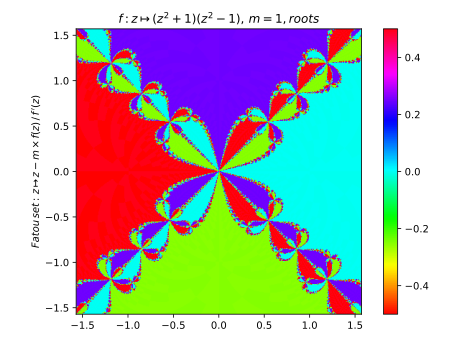

In [21]:
open("Figure_1.svg") do f
   display("image/svg+xml", read(f, String))
end

#### Ilustacja, w której kolor oznacza ilość iteracji wykonanych w punkcie

In [22]:
newton(:((z^2-1)*(z^2+1)),ϵ=0.01,N=25, iter=true,cmap="hsv") |> fatou |> plot

  0.051689 seconds (66.85 k allocations: 3.325 MiB)


UndefVarError: UndefVarError: plot not defined

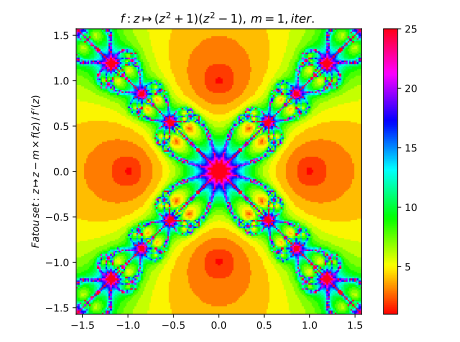

In [23]:
open("Figure_2.svg") do f
   display("image/svg+xml", read(f, String))
end